In [1]:
from web3 import Web3
import pandas as pd
import datetime
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from datetime import datetime
import logging, os, json

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
#key_1 = "4d08ab7e29294be397e15ec5503401ca"
key_2 = "d4d8ddd18ef6438ea49fd3d5006b7eba"
key_3 = "b7b06ad6a7304e2197efa10b79e1c867"
key_4 = "58bce48fe80b451c96fee8ef35bbcce8"

provider = "https://mainnet.infura.io/v3/"

In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = 'block_data'
pkl_file_path = os.path.join(data_dir, 'ethereum_transactions.pkl')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

        
def save_transactions_to_pkl(block_number, transactions_data):
    """Process and save block transaction data directly to a .pkl file."""
    try:
        if os.path.exists(pkl_file_path):
            df_existing = pd.read_pickle(pkl_file_path)
        else:
            df_existing = pd.DataFrame()

        for transaction in transactions_data:
            if 'timestamp' in transaction and isinstance(transaction['timestamp'], datetime):
                transaction['timestamp'] = transaction['timestamp'].isoformat()
            
            for key, value in transaction.items():
                if isinstance(value, np.int64):
                    transaction[key] = int(value)
                    
        df_new_transactions = pd.DataFrame(transaction)

        df_combined = pd.concat([df_existing, df_new_transactions], ignore_index=True)

        df_combined.to_pickle(pkl_file_path)
        logging.info(f"Block {block_number} transactions added to the .pkl file.")
    except Exception as e:
        logging.error(f"Error processing transactions for block {block_number}: {e}")


def load_block_data(block_number):
    """Check if block transaction data exists as a .pkl file."""
    file_path = os.path.join(data_dir, f'{block_number}.json')
    if os.path.exists(file_path):
        print(f'Block {block_number} data already exists')
        return True
    return False


provider_alchemy = "https://eth-mainnet.g.alchemy.com/v2/lv9CnJ8RqVk9hp-KRG2X_RS8wx3bNJbY"

w3 = Web3(Web3.HTTPProvider(provider_alchemy)) # provider_infura + key_4))
start_block = 18938321
end_block   = 18993488


transactions_data = []
block_range = np.arange(start_block, end_block + 1)
filtered_block_range = [block for block in block_range if not load_block_data(block)]

print(len(filtered_block_range)/len(block_range)*100,"% of blocks are new")

for block_number in filtered_block_range:
    block_number_int = int(block_number)
    block = w3.eth.get_block(block_number_int, full_transactions=True)
    block_timestamp = datetime.utcfromtimestamp(block.timestamp)
    
    for tx in block.transactions:
        tx_receipt = w3.eth.get_transaction_receipt(tx.hash)
        
        transactions_data.append({
            'block_number': block_number,
            'tx_hash': tx.hash.hex(),
            'gas_price': tx.gasPrice,
            'gas_used': tx_receipt.gasUsed,
            'timestamp': block_timestamp
        })
    
    
    
    save_block_data(block_number, transactions_data)

print("Dataframe saved. Number of transactions:", len(transactions_data))

df_transactions = pd.DataFrame(transactions_data)

df_transactions['gas_price_gwei'] = df_transactions['gas_price'].apply(lambda x: w3.from_wei(x, 'gwei')).astype(int)
df_transactions['tx_hash']        = df_transactions['tx_hash'].astype(str)
df_transactions['timestamp']      = pd.to_datetime(df_transactions['timestamp'])
df_transactions = df_transactions.set_index('timestamp').sort_index()

df_transactions.to_pickle('ethereum_transactions.pkl')

Block 18938321 data already exists
99.9981873549884 % of blocks are new


KeyboardInterrupt: 

In [10]:
def process_json_file(file_path):
    """Read a JSON file and convert it to a DataFrame."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    df['gas_price_gwei'] = df['gas_price'].apply(lambda x: Web3.from_wei(x, 'gwei'))
    return df

def save_df_to_csv(df, pkl_file_path):
    """Append a DataFrame to a .csv file, creating the file if it doesn't exist."""
    if os.path.exists(pkl_file_path):
        df.to_csv(pkl_file_path, mode='a', header=False, index=False)
    else:
        df.to_csv(pkl_file_path, mode='w', header=True, index=False)

directory = 'block_data'
pkl_file_path = os.path.join(directory, 'compiled_eth_tx_small.csv')
batch_size = 50

all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.json')]
all_files.sort()  # Optional: sort files if you need to process them in a specific order

for i in range(0, len(all_files), batch_size):
    batch_files = all_files[i:i+batch_size]
    frames = [process_json_file(file_path) for file_path in batch_files]
    df_batch = pd.concat(frames, ignore_index=True)
    df_batch['timestamp'] = pd.to_datetime(df_batch['timestamp'])
    save_df_to_csv(df_batch, pkl_file_path)
    print(f"Processed and saved batch {i//batch_size + 1}/{(len(all_files) - 1)//batch_size + 1}")

print("All data processed and saved.")


Processed and saved batch 1/1
All data processed and saved.


In [6]:
3*50


150

In [38]:
file_path = 'block_data/compiled_eth_tx_small.csv'
df = pd.read_csv(file_path, nrows=1000, encoding='ISO-8859-1', on_bad_lines='skip', quotechar='"', escapechar='\\')


df['gasPrice_eth'] = df['gas_price_gwei']*10**-9
df['tcost_usd'] = df['gasPrice_eth']*df['gas_used']

In [39]:
df.groupby('block_number').sum()

/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_3530/1206348240.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('block_number').sum()


,gas_price,gas_used,gas_price_gwei,gasPrice_eth,tcost_usd
block_number,,,,,
18937472,2846688809041,13212971,2846.688809,0.000003,0.263961
18937473,2926988820430,15941349,2926.988820,0.000003,0.339844
18937474,2221419869767,12270298,2221.419870,0.000002,0.227219
18937475,2466057233860,11904485,2466.057234,0.000002,0.238673
18937476,4966469407128,23180688,4966.469407,0.000005,0.477739
18937477,2570138754368,11505735,2570.138754,0.000003,0.284176
18937478,2976241507164,8286108,2976.241507,0.000003,0.271679


<Axes: >

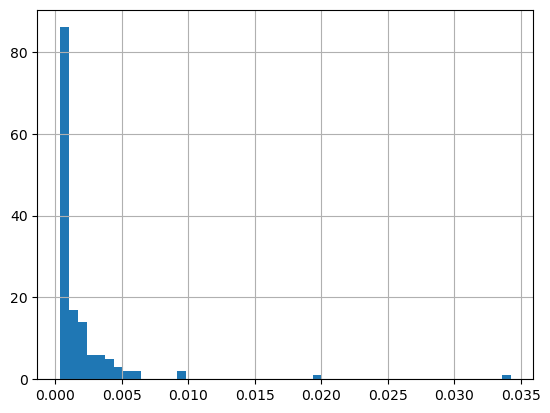

In [40]:
df[df.block_number == 18937472].sort_values('tcost_usd')['tcost_usd'].hist(bins=50)